# Distance calculate


Import libraries

In [153]:
import numpy as np
import cv2
from ultralytics import YOLO
import cv2
import math
import geocoder
import folium
import matplotlib.pyplot as plt

Open output.txt file to extract the paremeters calibrated by Camera_calibration.py

In [154]:
with open(r'D:\python\Distance_measurement\output.txt', 'r') as f:
    fx = float(f.readline().strip())
    fy = float(f.readline().strip())
    cy = float(f.readline().strip())
    ppx = float(f.readline().strip())
    ppy = float(f.readline().strip())
    cx = float(f.readline().strip())
print("fx = {},\nfy = {},\ncx = {},\nppx = {},\nppy = {},\ncy = {}".format(fx, fy, cx, ppx, ppy, cy))


fx = 2440.9540138328043,
fy = 2434.6728574963054,
cx = 2592.0,
ppx = 1248.1362594555521,
ppy = 957.0167856547552,
cy = 1944.0


Calculate focal length

In [155]:
mtx = np.array([[fx, 0, cx],
                [0, fy, cy],
                [0, 0, 1]])
# focal length
f = (fx + fy) / 2
display(mtx)
print("focal length = ", f)

array([[       2441,           0,        2592],
       [          0,      2434.7,        1944],
       [          0,           0,           1]])

focal length =  2437.813435664555


##### Applying YOLOv8

Defiine model and example image

In [156]:
model = YOLO("yolov8n.pt")
img = cv2.imread(r'D:\python\Distance_measurement\test10.jpg')


Extract xmin, xmax, ymin, ymax

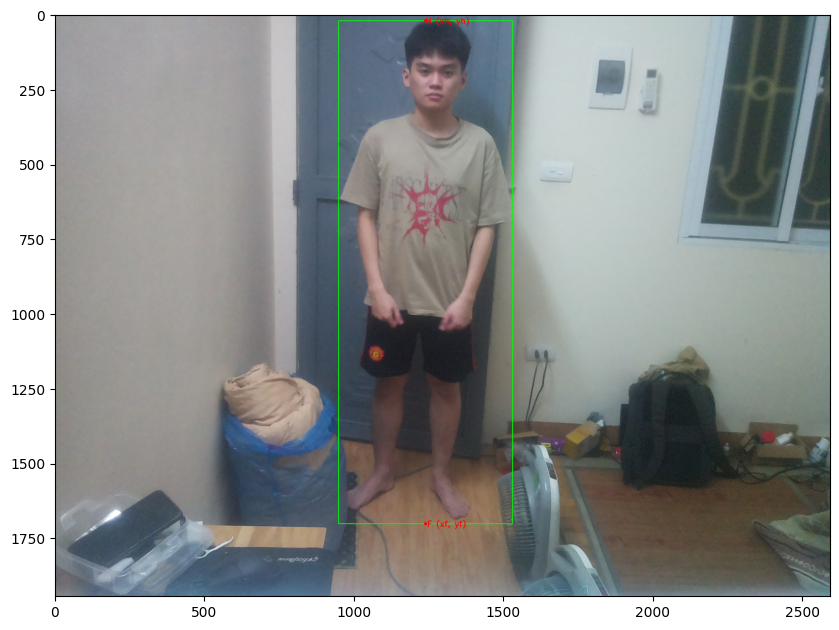

xmin = 948,
ymin = 22,
xmax = 1530,
ymax = 1702


In [157]:
CONFIDENCE_THRESHOLD = 0.8
GREEN = (0, 255, 0)

detections = model(img, verbose=False)[0]
for data in detections.boxes.data.tolist():
        # extract the confidence (i.e., probability) associated with the detection
        confidence = data[4]

        # filter out weak detections by ensuring the 
        # confidence is greater than the minimum confidence
        if float(confidence) < CONFIDENCE_THRESHOLD:
            continue

        # if the confidence is greater than the minimum confidence,
        # draw the bounding box on the frame
        xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
        cv2.rectangle(img, (xmin, ymin) , (xmax, ymax), GREEN, 2)
xf = int(0.5 * (xmin + xmax))
yf = int(ymax)

xh = int (0.5 * (xmin + xmax))
yh = int(ymin)

cv2.circle(img, (xf, yf), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (xh, yh), radius=5, color=(0, 0, 255), thickness=-1)

cv2.putText(img, "F (xf, yf)", (xf + 5, yf + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
cv2.putText(img, "H (xh, yh)", (xh, yh + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
print("xmin = {},\nymin = {},\nxmax = {},\nymax = {}".format(xmin, ymin, xmax, ymax))

##### Object depth estimation

In [158]:
# Extrinsic parameters (tham số ngoại bao gồm vị trí và hướng camera)
# Camera position
UAV_lat = 21.0037898
UAV_lon = 105.8430253

# Compass dỉection
p = 262                 # degrees

# Camera height
H = 0.85                # meters

# Camera angle
alpha = 75              # degrees

height = 0.85           # meters
distacne_meter = 1.63   # meters
distance_pixcel = 240   # pixcels

In [159]:
# Normalizzation
def meters_to_pixcel(x):
    return x * 240 / 1.63

def pixcel_to_meters(x):
    return x * 1.63 / 240

In [160]:
xn = (xf - cx) / fx
yn = (yf - cy) / fy
display(xn, yn)

-0.5542914746990704

-0.09939733761555981

In [162]:
# Human height
h = yf - yh     # pixel
print("Human height = {} in pixcel".format(h)) 
print("Human height: {} meters".format(pixcel_to_meters(h)))

Human height = 1680 in pixcel
Human height: 11.409999999999998 meters


In 2D image, human's height: 1680 (pixcel)<br>
In reality, approximate human's height: 1.7 (m)

In [ ]:
Zp      = H * (1 / math.cos(alpha))     # Zp = OP'
display(Zp)

0.9221576665186743

In [ ]:
P = (int(cx / 2), int(cy / 2), 0)
B = (0, int(P[1]), 0)
A = (int(P[0]), 0, 0)
O = (P[0], P[1], f)
C = (A[0], int(cy), 0)

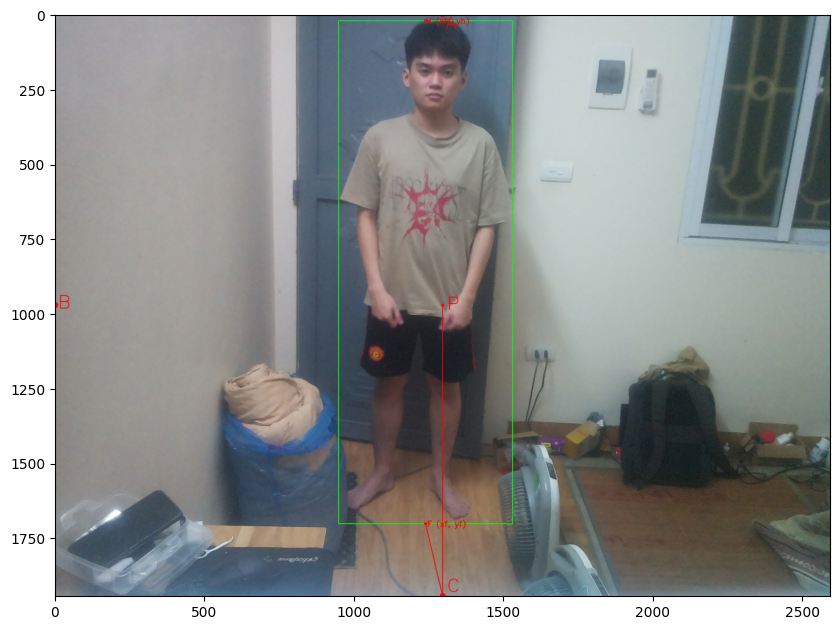

In [ ]:
cv2.circle(img, (B[0], B[1]), radius=10, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (A[0], A[1]), radius=10, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (P[0], P[1]), radius=5, color=(0, 0, 255), thickness=-1)
cv2.circle(img, (C[0], C[1]), radius=10, color=(0, 0, 255), thickness=-1)
cv2.putText(img, "B", (B[0] + 10, B[1] + 10), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
cv2.putText(img, "A", (A[0] + 10, A[1] + 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
cv2.putText(img, "P", (P[0] + 15, P[1] + 15), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
cv2.putText(img, "C", (C[0] + 15, C[1] - 15), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)
cv2.line(img, (C[0], C[1]), (P[0], P[1]), (0, 0, 255), thickness=2)
cv2.line(img, (C[0], C[1]), (xf, yf), (0, 0, 255), thickness=2)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()

In [ ]:
BP = int(math.sqrt((P[0] - B[0])**2 + (P[1] - B[1])**2 + (P[2] - B[2])**2))
AP = int(math.sqrt((P[0] - A[0])**2 + (P[1] - A[1])**2 + (P[2] - A[2])**2))
OP = f
F = (xf, yf, 0)
PF = int(math.sqrt((F[0] - P[0])**2 + (F[1] - P[1])**2))
tan_BOP = BP / OP
tan_AOP = AP / OP
print("BP = {} pixcel".format(BP))
print("AP = {} pixcel".format(AP))
print("OP = {} pixcel".format(OP))
print("PF = {} pixcel".format(PF))


BP = 1296 pixcel
AP = 972 pixcel
OP = 2437.813435664555 pixcel
PF = 732 pixcel


In [ ]:
vector_CP = np.array([P[0] - C[0], P[1] - C[1]])
vector_CF = np.array([F[0] - C[0], F[1] - C[1]])

beta = math.acos(np.dot(vector_CP, vector_CF) / (np.linalg.norm(vector_CP) * np.linalg.norm(vector_CF)))    
print("CP and CF angle: beta")
print("beta = {} degree".format(math.degrees(beta)))

CP and CF angle: beta
beta = 13.253715626495387 degree


In [ ]:
# focal lenght
f_pixcel = meters_to_pixcel(f/100)
print("focal lenght in pixcel = ", f_pixcel)
beta = math.atan(PF / f_pixcel)
print("beta = {} degree".format(math.degrees(beta)))

focal lenght in pixcel =  3589.418555579713
beta = 11.52643119151898 degree


In [ ]:
# Compass angle is given by sensor, so we have to calculate the direction of human
Human_direction = p + math.degrees(beta)
print("Human direction = {} degree".format(Human_direction))    

Human direction = 273.526431191519 degree


In [ ]:
Z = Zp * (1/math.cos(beta))
print("Z = {} meters".format(Z))

Z = 0.9411379439646419 meters


In [ ]:
dx = 1000 * f * tan_BOP
dy = 1000 * f * tan_AOP
print("dx = ", dx)
print("dy = ", dy)

dx =  1296000.0
dy =  972000.0


In [ ]:
sx = cx / dx
sy = cy / dy

d = math.sqrt(((cx - xf)/sx)**2 + ((cy -yf)/sy)**2)
teta = math.atan(d / f)
Z = Zp * (1/math.cos(teta))
xc = xn * Z
yc = yn * Z
zc = Z  
print("d = ", d)
print("Z = ", Z)


d =  687235.9492925265
Z =  259.96406340360215


Compass direction: p (input)<br>
Current location: (input)<br>

In [ ]:
xb = xc
yb = yc*math.cos(alpha)
zb = -yc*math.sin(alpha) + zc*math.cos(alpha)

E = zb*math.sin(math.radians(p)) + xb*math.cos(math.radians(p))
N = zb*math.cos(math.radians(p)) - xb*math.sin(math.radians(p))
U = -yb

display(E, N, U)

-207.31329111011527

-174.64795960406866

23.817809262760992

In [ ]:
b = math.atan(abs(E / N))
s = math.sqrt(E**2 + N**2)
dX = s*math.sin(b)
dY = s*math.cos(b)

In [ ]:
delta_lo = dX / (11320 * math.cos(math.radians(UAV_lon)))
delta_la = dY / 110540

In [ ]:
laf = UAV_lat + delta_la
lof = UAV_lon + delta_lo
display(laf, lof)

21.005369752592763

105.77594210684728

In [ ]:
m = folium.Map(location=[UAV_lat, UAV_lon], zoom_start=15)
folium.Marker(location=[UAV_lat, UAV_lon], popup='UAV').add_to(m)
folium.Marker(location=[laf, lof], popup='Target', icon=folium.Icon(color="red")).add_to(m)
m    